In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import time
import pickle
import os.path
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
import statsmodels.api as sm


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Scrape historical weather data

-  Create functions for scraping

In [102]:
url = 'https://www.almanac.com/weather/history/zipcode/10001/{}'

In [103]:

dates = pd.date_range('2015-1-1', '2015-6-30').strftime('%Y-%m-%d').tolist()

In [104]:
stats = ['temp','temp_mn','temp_mx', 'prcp', 'visib', 'sndp', 'slp', 'dewp', 'wdsp', 'mxspd', 'gust']

In [105]:
def get_soup(date):
    url_f = url.format(date)
    response = requests.get(url_f)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup

In [106]:
def get_stat(stats,dates): #stat argument is meant to modify the class in the B.S. find_all function for different features. 
    dic = defaultdict(list) #initialize dict to map date with value
    for date in dates:
        for stat in stats:
            soup = get_soup(date)
            val = "weatherhistory_results_datavalue {}".format(stat)
            if not soup.find('tr', {'class': val}).find('span', {'class': ['value']}):
                dic[date].append(soup.find('tr', {'class': val}).find('span', {'class': ['value']})) #where our value lives
            elif soup.find('tr', {'class': val}):
                dic[date].append(soup.find('tr', {'class': val}).find('span', {'class': ['value']}).text) #where our value lives
        print(date, dic[date])
        #time.sleep(4)
    return dic

-  Scrape:

In [108]:
#january = get_stat(stats, dates[0:31]) 

#february = get_stat(stats, dates[31:59]) 

#march = get_stat(stats, dates[59:90]) 

#april = get_stat(stats, dates[90:120])

#may = get_stat(stats, dates[120:151])

#june = get_stat(stats, dates[151:181])

In [22]:
def make_csv(month, fn):
    df = pd.DataFrame(month).transpose()
    df.to_csv('{}'.format(fn))

## Make DF from Taxi files - taxidf, taxi_hourly_counts

In [3]:
taxifiles = ['2015-01','2015-02','2015-03','2015-04','2015-05','2015-06']
taxicsvs = ['taxidf1.csv','taxidf2.csv','taxidf3.csv','taxidf4.csv','taxidf5.csv','taxidf6.csv']
for i, v in enumerate(taxifiles):
    df = pd.read_csv('yellowcab/yellow_tripdata_'+v+'.csv')
    df=df.drop(['RateCodeID','store_and_fwd_flag','improvement_surcharge','tolls_amount','VendorID','passenger_count'],axis=1)
    df['Date'] = [x.split()[0] for x in df['tpep_pickup_datetime']]
    df['Time'] = [x.split()[1] for x in df['tpep_pickup_datetime']]
    df.Time = pd.to_datetime(df.Time)
    df['Hour']=[d.hour for d in df.Time]
    df = df.groupby(['Date','Hour'])['total_amount'].count().reset_index()
    df.to_csv(taxicsvs[i])

-  Mask for filtering out airport trips (future steps):

In [ ]:
#mask_jfk = ((((df['pickup_longitude']>= -73.783074 + 3/52 )|
#       (df['pickup_longitude']<= -73.783074 - 3/52 ))&
#       ((df['pickup_latitude']>= 40.64561 + 3/69 )|
#       (df['pickup_latitude']<= 40.64561 - 3/69 )))|
#      (((df['dropoff_longitude']>= -73.783074 + 3/52 )|
#       (df['dropoff_longitude']<= -73.783074 - 3/52 ))&
#       ((df['dropoff_latitude']>= 40.64561 + 3/69 )|
#       (df['dropoff_latitude']<= 40.64561 - 3/69 ))))
#    mask_lga = ((((df['pickup_longitude']>= -73.872127 + .5/52 )|
#       (df['pickup_longitude']<= -73.872127 - .5/52 ))&
#       ((df['pickup_latitude']>= 40.774068 + .5/69 )|
#       (df['pickup_latitude']<= 40.774068 - .5/69 )))|
#      (((df['dropoff_longitude']>= -73.872127 + .5/52 )|
#       (df['dropoff_longitude']<= -73.872127 - .5/52 ))&
#       ((df['dropoff_latitude']>= 40.774068 + .5/69 )|
#       (df['dropoff_latitude']<= 40.774068 - .5/69 ))))

#### Concat smaller taxi CSVs

In [4]:
taxi_hourly_counts = pd.concat([pd.read_csv(csv) for csv in taxicsvs], ignore_index=True)

In [5]:
taxi_hourly_counts.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
#taxi_hourly_counts.to_pickle('taxi_hourly_counts.pkl')

## Make DFs from  weather data (Almanac and Frontier) and combine them 

In [8]:
month_labels = ['january15', 'february15',
                'march15', 'april15', 'may15', 'june15']

monthsdf = pd.concat([pd.read_csv('almanac/'+month+'.csv')
                      for month in month_labels], ignore_index=True)

# Scraped data didn't have column names. Make them here:

monthsdf = monthsdf.rename(columns={'Unnamed: 0': 'DATE', '0': 'MEAN_TEMP', '1': 'LOW_TEMP',
                                    '2': 'HIGH_TEMP', '3': 'PRECIP',
                                    '4': 'VISIB', '5': 'SNOW_DEPTH', '6': 'PRESSURE',
                                    '7': 'DEW_PT', '8': 'WIND_SP', '9': 'MAX_WIND', '10': 'GUST'})

monthsdf.DATE = pd.to_datetime(monthsdf['DATE'])

In [9]:
frontierdf = pd.read_csv('http://www.frontierweather.com/historicaldataonly/KNYC.txt', parse_dates=['Date'])

frontierdf=frontierdf[((frontierdf.Date>='2015-01-01')&(frontierdf.Date<='2015-06-30'))]

In [10]:
weatherdf = pd.merge(monthsdf, frontierdf, left_on='DATE', right_on='Date')

weatherdf = weatherdf.drop(['VISIB', 'SNOW_DEPTH','GUST','MAX_WIND','DEW_PT','Date','Site', 'Dewpoint', 'RH', 'WindDir', 'Windspeed', 'CldFrac', 'MSLP', 'Source'], axis=1)

In [11]:
# There are too many weather categories, generalize them to only 4 with replace().

weatherdf.Weather = weatherdf.Weather.replace(dict(zip(['SCT', 'FEW', 'OVC','BKN','HZ','FG'],['CLR']*6)))

weatherdf.Weather = weatherdf.Weather.replace(dict(zip(['-SN', '-SN BR', '-SN FZFG','SN','SN FG','SN FZFG','UP','UP BR'],['SN']*8)))

weatherdf.Weather = weatherdf.Weather.replace(dict(zip([ '-RA BR', 'RA','RA FG','RA BR','-RA','BR'],['RA']*6)))

weatherdf.Weather = weatherdf.Weather.replace(dict(zip(['+RA FG', '+RA BR', '-FZRA BR','-FZRA'],['+RA']*4)))

In [12]:
weatherdf.head()

,DATE,MEAN_TEMP,LOW_TEMP,HIGH_TEMP,PRECIP,PRESSURE,WIND_SP,Hour,Temperature,Weather,Precip
0,2015-01-01,31.1,27.0,39.4,0.0,30.13,0.0,0,28,CLR,0.0
1,2015-01-01,31.1,27.0,39.4,0.0,30.13,0.0,1,28,CLR,0.0
2,2015-01-01,31.1,27.0,39.4,0.0,30.13,0.0,2,28,CLR,0.0
3,2015-01-01,31.1,27.0,39.4,0.0,30.13,0.0,3,27,CLR,0.0
4,2015-01-01,31.1,27.0,39.4,0.0,30.13,0.0,4,27,CLR,0.0


## Make DF from Uber data

In [13]:
uberdf = pd.read_csv('uber/uber-raw-data-janjune-15.csv', parse_dates=['Pickup_date'])

uberdf['Date'] = [d.date() for d in uberdf['Pickup_date']]

uberdf['Time'] = [d.time() for d in uberdf['Pickup_date']]

uberdf['Hour']=[d.hour for d in uberdf['Time']]

uberdf['Date'] = pd.to_datetime(uberdf['Date'])

## Combine Uber and Weather

In [14]:
uber_weather = pd.merge(uberdf,weatherdf, left_on=['Date', 'Hour'], right_on=['DATE', 'Hour'])

In [15]:
uber_hourly_counts = uber_weather.groupby(['Date','Hour'])['Pickup_date'].count().reset_index()

uber_hourly_counts = uber_hourly_counts.rename(columns={'Pickup_date':'Trips'})

In [16]:
uber_weather_hourly=pd.merge(uber_hourly_counts,weatherdf, left_on=['Date','Hour'], right_on=['DATE','Hour'])



In [17]:
uber_weather_hourly=uber_weather_hourly.drop(['DATE'],axis=1)

In [18]:
#uber_weather_hourly.to_pickle('uber_weather_hourly.pkl')

In [96]:
#uber_weather_hourly = pd.read_pickle('uber_weather_hourly.pkl')

## Combine Taxi and Weather


In [22]:
#taxi_hourly_counts = pd.read_pickle('taxi_hourly_counts.pkl')

In [19]:
taxi_hourly_counts.Date = pd.to_datetime(taxi_hourly_counts.Date)

In [20]:
taxi_weather_hourly = pd.merge(taxi_hourly_counts,weatherdf, left_on=['Date','Hour'], right_on=['DATE','Hour'])


In [21]:
#taxi_weather_hourly.to_pickle('taxi_weather_hourly.pkl')

# Uber, Taxi, Weather - Main DataFrame

In [32]:
uber_taxi_weather = pd.merge(taxi_hourly_counts, uber_weather_hourly, on=['Date', 'Hour'])

In [33]:
uber_taxi_weather = uber_taxi_weather.rename(columns={'total_amount':'Yellowcab', 'Trips':'Uber'})

Make 'Day' column for dummies and 'Day_I' column with index of every weekday (Sunday = 1, Monday = 2, etc) for OLS.

In [34]:
uber_taxi_weather['Day']= uber_taxi_weather['Date'].dt.day_name()

In [35]:
uber_taxi_weather['Day_I'] = uber_taxi_weather['Day'].replace({'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7, })

### Main data frame pickle: uber_taxi_weather.pkl

In [4]:
uber_taxi_weather = pd.read_pickle('uber_taxi_weather.pkl')

-------------------

# Exploratory Data Analysis
### Two weeks of Yellowcab (including Superbowl Sunday)

-  Reason for adding 'Day' columns

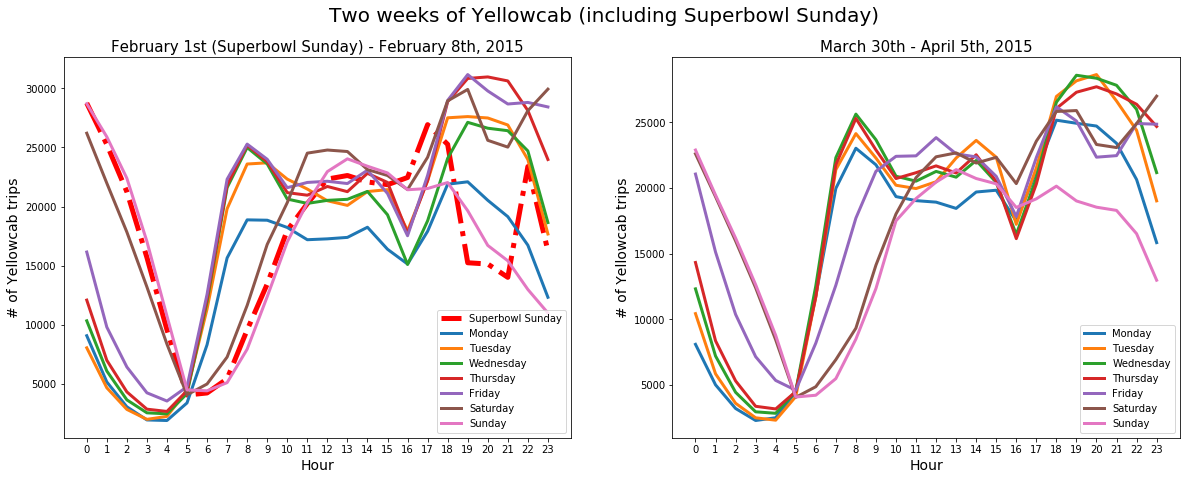

In [62]:

plt.figure(figsize=(20,7));
plt.suptitle('Two weeks of Yellowcab (including Superbowl Sunday)', y=.98, size=20)

# Taxi plot 1

plt.subplot(1,2,1);
plt.title('February 1st (Superbowl Sunday) - February 8th, 2015', size=15);
plt.xlabel('Hour', size=14)
plt.ylabel('# of Yellowcab trips', size=14)
plt.xticks(range(24))
labels = []
for i in pd.date_range(start='2015-02-01',end='2015-02-08'):
    month = uber_taxi_weather.set_index('Date').loc[i]
    if str(i.date()) == '2015-02-01':
        labels.append('Superbowl Sunday')
        plt.plot(month.Hour, month.Yellowcab, linewidth=5, linestyle='-.', color='r');
    else:
        labels.append(i.day_name())
        plt.plot(month.Hour, month.Yellowcab, linewidth=3);
plt.legend(labels, loc=4);

#Taxi plot 2:

plt.subplot(1,2,2)
plt.title('March 30th - April 5th, 2015', size=15);
labels = []
plt.xticks(range(24))
plt.xlabel('Hour', size=14)
plt.ylabel('# of Yellowcab trips', size=14)
for i in pd.date_range(start='2015-03-30',end='2015-04-05'):
    
    month = uber_taxi_weather.set_index('Date').loc[i]
    if str(i.date()) == '2015-02-01':
        labels.append('Superbowl Sunday')
        plt.plot(month.Hour, month.Yellowcab, linewidth=5, linestyle='-.', color='r');
    else:
        labels.append(i.day_name())
        plt.plot(month.Hour, month.Yellowcab, linewidth=3);
plt.legend(labels, loc=4);

plt.savefig('two_weeks_taxi')

## Two weeks of Uber (including Superbowl Sunday)

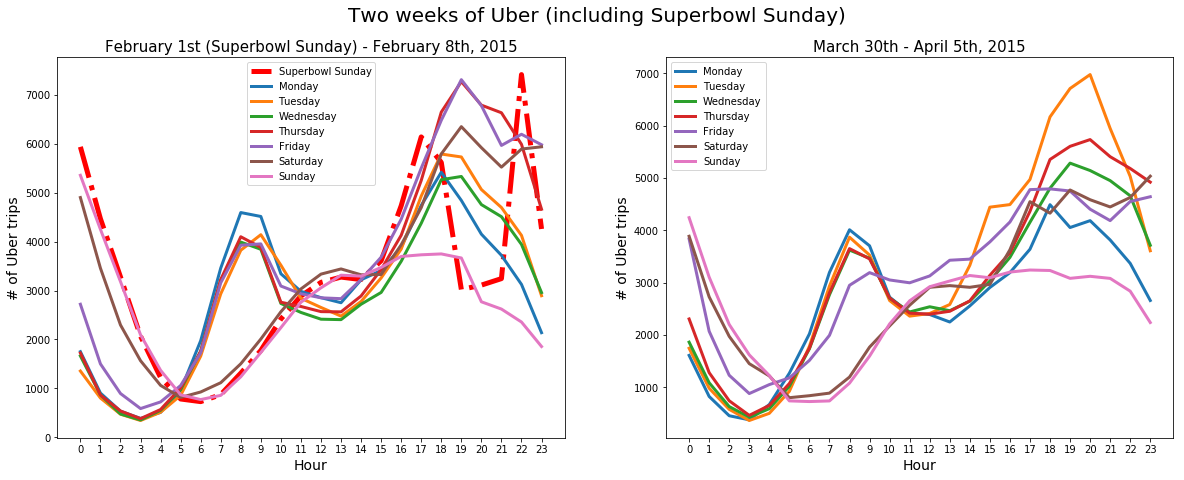

In [64]:

plt.figure(figsize=(20,7));
plt.suptitle('Two weeks of Uber (including Superbowl Sunday)', y=.98, size=20)

#Uber plot 1

plt.subplot(1,2,1);
plt.title('February 1st (Superbowl Sunday) - February 8th, 2015', size=15);
plt.xlabel('Hour', size=14)
plt.ylabel('# of Uber trips', size=14)
plt.xticks(range(24))
labels = []
for i in pd.date_range(start='2015-02-01',end='2015-02-08'):
    
    month = uber_taxi_weather.set_index('Date').loc[i]
    if str(i.date()) == '2015-02-01':
        labels.append('Superbowl Sunday')
        plt.plot(month.Hour, month.Uber, linewidth=5, linestyle='-.', color='r');
    else:
        labels.append(i.day_name())
        plt.plot(month.Hour, month.Uber, linewidth=3);
plt.legend(labels);

#Uber plot 2

plt.subplot(1,2,2)
plt.title('March 30th - April 5th, 2015', size=15);
plt.xlabel('Hour', size=14)
plt.xticks(range(24))
plt.ylabel('# of Uber trips', size=14)
labels = []
for i in pd.date_range(start='2015-03-30',end='2015-04-05'):
    month = uber_taxi_weather.set_index('Date').loc[i]
    if str(i.date()) == '2015-02-01':
        labels.append('Superbowl Sunday')
        plt.plot(month.Hour, month.Uber, linewidth=5, linestyle='-.', color='r');
    else:
        labels.append(i.day_name())
        plt.plot(month.Hour, month.Uber, linewidth=3);
plt.legend(labels);

plt.savefig('two_weeks_uber')

## Mean temperature over time:

(Sanity check)

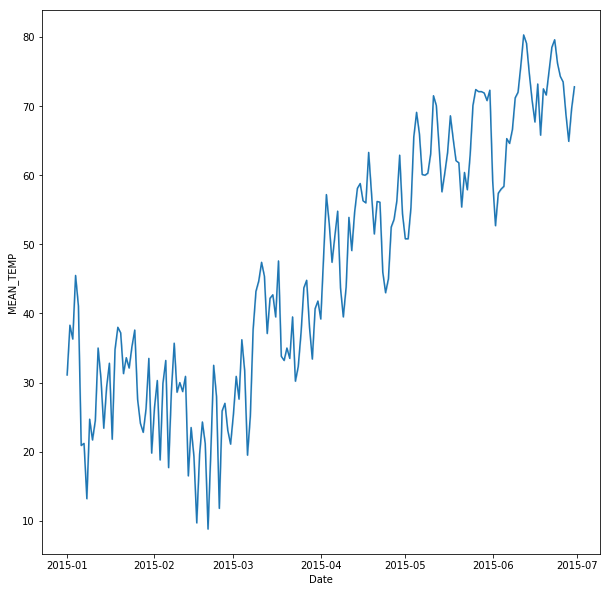

In [237]:
plt.figure(figsize=(10,10));
sns.lineplot(uber_taxi_weather.Date, uber_taxi_weather.MEAN_TEMP)

Looks like the taxi, uber, and weather data all generally make sense: Ridership is busiest during morning and evening rush hours and before/after large events. Mean temperature from our scraped data rises over our collection period.

#  Heatmap & Pairplot

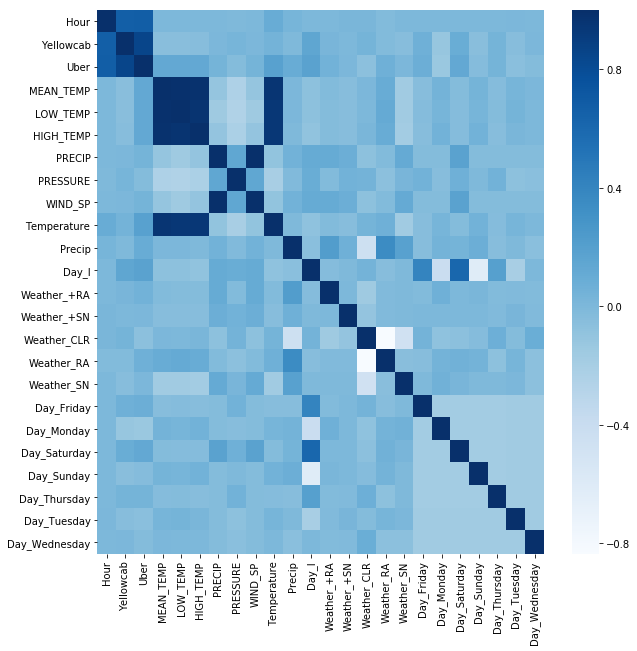

In [129]:
plt.figure(figsize=(10,10));
sns.heatmap(pd.get_dummies(uber_taxi_weather).corr(), cmap='Blues');

plt.savefig('heatmap')

<Figure size 720x720 with 0 Axes>

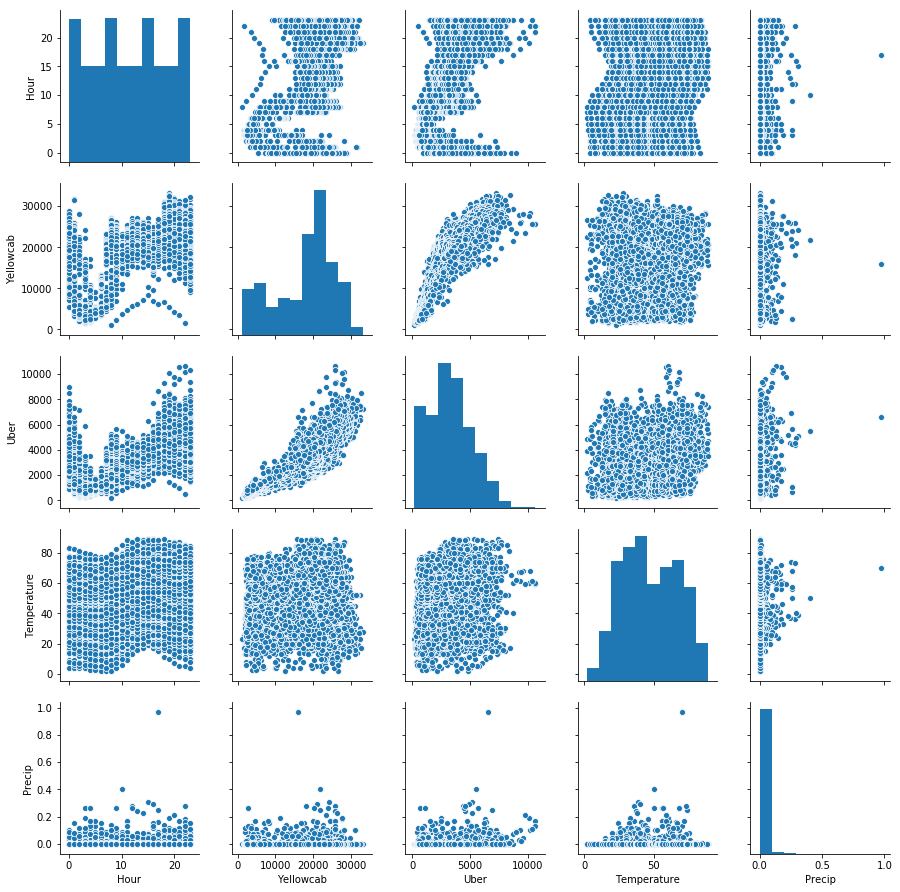

In [66]:
plt.figure(figsize=(10,10));
sns.pairplot(uber_taxi_weather.loc[:,['Hour','Yellowcab','Uber','Temperature','Precip']]);

plt.savefig('pairplot')

#  Run regression - can we predict Uber ridership based on weather?


#### Let's first see how well we can predict Uber ridership based on only hour and day of week with a simple model:

In [127]:
X = uber_taxi_weather.loc[:,['Hour','Day_I','Uber']]

In [128]:
X_train, X_test, y_train, y_test = train_test_split((X.loc[:,['Hour', 'Day_I']]), X.Uber, test_size=0.33, random_state=42)

In [129]:
m = LinearRegression()
m.fit(X_train, y_train)
m.score((X_test),y_test) 

0.5069704336101164

## SKLEARN

#### Let's add weather data.

In [130]:
X = uber_taxi_weather.loc[:,['Hour', 'Temperature','Weather','Precip','Day_I','Uber']]
X['Hour2'] = X['Hour']**2
X['Temperature2'] = X['Temperature']**2

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['Hour','Hour2','Temperature','Temperature2', 'Precip', 'Day_I']], X['Uber'], test_size=0.33, random_state=42)

In [132]:
m = LinearRegression()
m.fit(X_train, y_train)
m.score((X_test),y_test)   

0.5654557802126063

#### Add PolynomialFeatures:

In [133]:
X_train, X_test, y_train, y_test = train_test_split(uber_taxi_weather[['Hour','Temperature', 'Precip', 'Day_I']], uber_taxi_weather['Uber'], test_size=0.33, random_state=42)


In [134]:
m = LinearRegression()
p = PolynomialFeatures(degree = 4)
m.fit(p.fit_transform(X_train),y_train)
#m.score(p.transform(X_train),y_train)
m.score(p.transform(X_test),y_test)

0.7391367204019427

### What if we add Yellowcab ridership data?

In [135]:
X = (uber_taxi_weather.loc[:,['Yellowcab','Hour', 'Temperature','Weather','Precip','Day_I','Uber']])
X['Hour2'] = X['Hour']**2
X['Temperature2'] = X['Temperature']**2
X['Yellowcab2'] = X['Yellowcab']**2

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['Hour','Hour2','Temperature','Temperature2','Yellowcab','Yellowcab2', 'Precip', 'Day_I']], X['Uber'], test_size=0.33, random_state=42)

In [137]:
m = LinearRegression()
m.fit(X_train, y_train)
m.score((X_test),y_test)

0.8606024594042577

#### Add Polynomial Features 


In [233]:
X = (uber_taxi_weather.loc[:,['Yellowcab','Hour', 'Temperature','Weather','Precip','Day_I','Uber']])

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['Hour','Temperature','Yellowcab', 'Precip', 'Day_I']], X['Uber'], test_size=0.33, random_state=42)

In [235]:
p = PolynomialFeatures(degree = 4)
m.fit(p.fit_transform(X_train),y_train)
#m.score(p.transform(X_train),y_train)
m.score(p.transform(X_test),y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.08152e-39): result may not be accurate.
  overwrite_a=True).T


0.9151836148723973

### Try Ridge

#### Scale features:

In [200]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [201]:
X_tr = std.transform(X_train.values)

In [202]:
X_te = std.transform(X_test.values)

In [204]:
m = Ridge(alpha=1)
p = PolynomialFeatures(degree=4)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_test),y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.08152e-39): result may not be accurate.
  overwrite_a=True).T


0.9151836148723973

-  Try out RidgeCV()

In [183]:
X2 = uber_taxi_weather.loc[:,['Yellowcab','Hour', 'Temperature','Precip','Day_I']]
y2 = uber_taxi_weather.Uber
# std.fit(X2.values)

In [195]:
std = StandardScaler()
ridge_model = RidgeCV()
p = PolynomialFeatures(degree=4)
ridge_model.fit(std.fit_transform(p.fit_transform(X2)),y2)
ridge_model.score(std.transform(p.transform(X2)),y2)

0.903211387823966

In [190]:
ridge_model.alpha_

10.0

Our R^2 = .915 with PolynomialFeatures(degree=4) and Ridge(alpha=1)

## STATSMODEL

In [148]:
X = uber_taxi_weather.loc[:,['Uber', 'Yellowcab', 'Hour', 'Temperature', 'Weather', 'Precip', 'Day']]
X['Hour2'] = X['Hour']**2
X['Temperature2'] = X['Temperature']**2
#X['Yellowcab2'] = X['Yellowcab']**2

In [149]:
# Define the model
lm1 = sm.OLS(X.Uber, pd.get_dummies(X.loc[:,['Yellowcab', 'Hour','Hour2', 'Temperature','Temperature2', 'Weather', 'Precip', 'Day']],drop_first=True))

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Uber   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     7233.
Date:                Thu, 24 Jan 2019   Prob (F-statistic):               0.00
Time:                        18:56:21   Log-Likelihood:                -34623.
No. Observations:                4334   AIC:                         6.928e+04
Df Residuals:                    4318   BIC:                         6.938e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Yellowcab         0.1763      0.002     92.138      0.000       0.173       0.180
Hour           -159.3668      6.498    -24.527      0.000    -172.105    -146.628
Hour2             8.6907      0.257     33.813      0.000       8.187       9.195
Temperature     -25.5468      2.741     -9.321      0.000     -30.920     -20.173
Temperature2      0.4290      0.028     15.359      0.000       0.374       0.484
Precip         5746.1126    447.337     12.845      0.000    4869.103    6623.122
Weather_+SN    1343.4798    300.154      4.476      0.000     755.024    1931.935
Weather_CLR     575.3431     69.942      8.226      0.000     438.221     712.465
Weather_RA      960.2249     83.748     11.466      0.000     796.036    1124.414
Weather_SN     1221.4077     92.525     13.201      0.000    1040.012    1402.803
Day_Monday     -406.4259     40.787     -9.965      0.000    -486.390    -326.462
Day_Saturday     98.4420     40.445      2.434      0.015      19.150     177.734
Day_Sunday     -190.6976     40.803     -4.674      0.000    -270.691    -110.704
Day_Thursday    -25.6264     40.427     -0.634      0.526    -104.883      53.630
Day_Tuesday    -339.6949     40.620     -8.363      0.000    -419.331    -260.059
Day_Wednesday  -244.5113     40.933     -5.973      0.000    -324.760    -164.262
==============================================================================
Omnibus:                      382.359   Durbin-Watson:                   0.396
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.056
Skew:                           0.649   Prob(JB):                    6.86e-137
Kurtosis:                       4.338   Cond. No.                     8.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Back to step 1, we can actually predict more than we thought with just Hour and Day using a more complex model

In [215]:
X = uber_taxi_weather.loc[:,['Hour','Day_I','Uber']]

In [216]:
X_train, X_test, y_train, y_test = train_test_split((X.loc[:,['Hour', 'Day_I']]), X.Uber, test_size=0.33, random_state=2)

In [221]:
std = StandardScaler()

m = Ridge()
p = PolynomialFeatures(degree=8)
m.fit(p.fit_transform(std.fit_transform(X_train)),y_train)
m.score(p.transform(std.transform(X_test)),y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


0.8022477179425966

# Further Steps

 -   Make a 'Major Event' column that accounts for major events (concerts, sports) at MSG, Barclays, etc.  
 -  Make a 'Mean Distance' column for each hour, change target to see if trip distance is determined by hour and weather
 -  Make a 'Major Holiday' column that accounts for weather a day is a holiday (e.g. July 4th) or national event (e.g. the Superbowl).
 -  Filter out trips to JFK and LGA to see if airport trips are less affected by weather

## PICKLES

  
weatherdf.pkl    
taxi_hourly_counts.pkl  
uber_hourly_counts.pkl  
uber_taxi_weather.pkl  



---------